In [ ]:
"""
Necessary packages
"""

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
import shap

In [2]:
"""
Load in data
"""

'\nLoad in data\n'

In [3]:
# Set plot style
sns.set(style='whitegrid')

# File paths (adjust if needed)
all_attendances_fp = "hosp-epis-stat-outp-all-firs-atte-2023-24-data.csv"
imd_ethnicity_fp = "hosp-epis-stat-outp-eth-imd-dec-2023-24-data.csv"
specialty_fp = "hosp-epis-stat-outp-main-spec-tret_spec-2023-24-data.csv"

# Load datasets
df_attend = pd.read_csv(all_attendances_fp)
df_imd_eth = pd.read_csv(imd_ethnicity_fp)
df_spec = pd.read_csv(specialty_fp)

# Preview structure
print("Attendances data:")
display(df_attend.head())
print("\nIMD + Ethnicity data:")
display(df_imd_eth.head())
print("\nSpeciality data:")
display(df_spec.head())

Attendances data:


,REPORTING_PERIOD,MEASURE_TYPE,MEASURE,MAINSPEF_CODE,MAINSPEF_DESCRIPTION,MEASURE_VALUE
0,2324,All Attendances by Age and Gender,0 All Genders,All,All,1173424
1,2324,All Attendances by Age and Gender,0 Female,All,All,530786
2,2324,All Attendances by Age and Gender,0 Male,All,All,624127
3,2324,All Attendances by Age and Gender,10-14 All Genders,All,All,2841219
4,2324,All Attendances by Age and Gender,10-14 Female,All,All,1333123



IMD + Ethnicity data:


,REPORTING_PERIOD,MEASURE_TYPE,MEASURE,MEASURE_VALUE
0,2324,Activity by Ethnicity,All Attendances - African (Black or Black Brit...,1867146.0
1,2324,Activity by Ethnicity,All Attendances - All Ethnic Groups,104634817.0
2,2324,Activity by Ethnicity,All Attendances - Any other Asian background,1630280.0
3,2324,Activity by Ethnicity,All Attendances - Any other Black background,745149.0
4,2324,Activity by Ethnicity,All Attendances - Any other ethnic group,2495444.0



Speciality data:


,REPORTING_PERIOD,MEASURE_TYPE,MEASURE,CODE,CODE_DESCRIPTION,MEASURE_VALUE
0,2324,Activity by Main Speciaity Code,All Attendances,100,General Surgery,4954058.0
1,2324,Activity by Main Speciaity Code,All Attendances,101,Urology,2765938.0
2,2324,Activity by Main Speciaity Code,All Attendances,107,Vascular Surgery,47786.0
3,2324,Activity by Main Speciaity Code,All Attendances,110,Trauma & Orthopaedics,7280703.0
4,2324,Activity by Main Speciaity Code,All Attendances,120,"Ear, Nose & Throat (ENT)",2814999.0


In [4]:
print(df_attend.head())
print(df_imd_eth.head())
print(df_spec.head())

   REPORTING_PERIOD                       MEASURE_TYPE            MEASURE  \
0              2324  All Attendances by Age and Gender      0 All Genders   
1              2324  All Attendances by Age and Gender           0 Female   
2              2324  All Attendances by Age and Gender             0 Male   
3              2324  All Attendances by Age and Gender  10-14 All Genders   
4              2324  All Attendances by Age and Gender       10-14 Female   

  MAINSPEF_CODE MAINSPEF_DESCRIPTION  MEASURE_VALUE  
0           All                  All        1173424  
1           All                  All         530786  
2           All                  All         624127  
3           All                  All        2841219  
4           All                  All        1333123  
   REPORTING_PERIOD           MEASURE_TYPE  \
0              2324  Activity by Ethnicity   
1              2324  Activity by Ethnicity   
2              2324  Activity by Ethnicity   
3              2324  Activity

In [5]:
"""
Cross-join datasets
"""

'\nCross-join datasets\n'

In [6]:
# Step 1: Clean up ethnic groups from df_imd_eth
df_ethnicity = df_imd_eth[df_imd_eth["MEASURE_TYPE"] == "Activity by Ethnicity"].copy()
df_ethnicity["Ethnic Group"] = df_ethnicity["MEASURE"].str.extract(r'All Attendances - (.*)')
df_ethnicity = df_ethnicity.dropna(subset=["Ethnic Group"])

# Step 2: Clean up specialties from df_spec
df_spec_clean = df_spec[(df_spec["MEASURE_TYPE"] == "Activity by Main Speciaity Code") &
                        (df_spec["MEASURE"] == "All Attendances")].copy()
df_spec_clean = df_spec_clean.rename(columns={
    "CODE_DESCRIPTION": "Specialty"
})

# Step 3: Filter top 10 values for simplicity
top_ethnicities = df_ethnicity["Ethnic Group"].value_counts().nlargest(10).index.tolist()
ethnicities = df_ethnicity[df_ethnicity["Ethnic Group"].isin(top_ethnicities)]["Ethnic Group"].unique()

top_specialties = df_spec_clean["Specialty"].value_counts().nlargest(10).index.tolist()
specialties = df_spec_clean[df_spec_clean["Specialty"].isin(top_specialties)]["Specialty"].unique()

# Step 4: Extract age and gender values from df_attend
df_attend_clean = df_attend[df_attend["MEASURE_TYPE"] == "All Attendances by Age and Gender"].copy()
df_attend_clean[["Age Group", "Gender"]] = df_attend_clean["MEASURE"].str.extract(r'^(.*?)\s+(All Genders|Female|Male)$')
df_attend_clean = df_attend_clean[df_attend_clean["Age Group"] != "Age Unknown"]
age_groups = df_attend_clean["Age Group"].unique()
genders = df_attend_clean["Gender"].unique()

# Step 5: Create Cartesian product (cross join)
group_combinations = list(product(age_groups, genders, ethnicities, specialties))
df_combined = pd.DataFrame(group_combinations, columns=["Age Group", "Gender", "Ethnic Group", "Specialty"])

# Preview
df_combined.head()

,Age Group,Gender,Ethnic Group,Specialty
0,0,All Genders,African (Black or Black British),General Surgery
1,0,All Genders,African (Black or Black British),Urology
2,0,All Genders,African (Black or Black British),Gynaecology
3,0,All Genders,African (Black or Black British),Community Sexual & Reproductive Health
4,0,All Genders,African (Black or Black British),Midwife episode


In [7]:
"""
Generate Synthetic DNA rate
"""

'\nGenerate Synthetic DNA rate\n'

In [8]:
import numpy as np

np.random.seed(42)

def age_factor(age_group):
    if "-" in age_group:
        age = int(age_group.split("-")[0])
    elif age_group.isdigit():
        age = int(age_group)
    else:
        return 0.01
    return 0.10 if age < 25 else 0.06 if age < 65 else 0.03

def gender_factor(gender):
    return 0.08 if gender == "Male" else 0.06 if gender == "Female" else 0.07

def ethnicity_factor(ethnic_group):
    high_risk = ["Black", "Mixed", "Bangladeshi", "Caribbean"]
    return 0.10 if any(x in ethnic_group for x in high_risk) else 0.06

def specialty_factor(specialty):
    if "mental" in specialty.lower():
        return 0.15
    elif "midwife" in specialty.lower():
        return 0.10
    else:
        return 0.04

# Apply new synthetic DNA rate model
df_combined["DNA_Rate"] = df_combined.apply(lambda row: np.clip(
    age_factor(row["Age Group"]) +
    gender_factor(row["Gender"]) +
    ethnicity_factor(row["Ethnic Group"]) +
    specialty_factor(row["Specialty"]) +
    np.random.normal(0, 0.01), 0.05, 0.40), axis=1)

# Check result again
df_combined["DNA_Rate"].describe()

count    7200.000000
mean        0.271745
std         0.050592
min         0.163819
25%         0.234747
50%         0.267118
75%         0.303401
max         0.400000
Name: DNA_Rate, dtype: float64

In [9]:
print(df_combined.head(50))

   Age Group       Gender                        Ethnic Group  \
0          0  All Genders    African (Black or Black British)   
1          0  All Genders    African (Black or Black British)   
2          0  All Genders    African (Black or Black British)   
3          0  All Genders    African (Black or Black British)   
4          0  All Genders    African (Black or Black British)   
5          0  All Genders    African (Black or Black British)   
6          0  All Genders    African (Black or Black British)   
7          0  All Genders    African (Black or Black British)   
8          0  All Genders    African (Black or Black British)   
9          0  All Genders    African (Black or Black British)   
10         0  All Genders  Caribbean (Black or Black British)   
11         0  All Genders  Caribbean (Black or Black British)   
12         0  All Genders  Caribbean (Black or Black British)   
13         0  All Genders  Caribbean (Black or Black British)   
14         0  All Genders

In [10]:
# General info
df_combined.info()

# Descriptive stats for DNA_Rate
print(df_combined["DNA_Rate"].describe())

# Number of unique values in each column
print(df_combined.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age Group     7200 non-null   object 
 1   Gender        7200 non-null   object 
 2   Ethnic Group  7200 non-null   object 
 3   Specialty     7200 non-null   object 
 4   DNA_Rate      7200 non-null   float64
dtypes: float64(1), object(4)
memory usage: 281.4+ KB
count    7200.000000
mean        0.271745
std         0.050592
min         0.163819
25%         0.234747
50%         0.267118
75%         0.303401
max         0.400000
Name: DNA_Rate, dtype: float64
Age Group         24
Gender             3
Ethnic Group      10
Specialty         10
DNA_Rate        7068
dtype: int64


In [11]:
"""
Describing the DNA rates
"""

'\nDescribing the DNA rates\n'

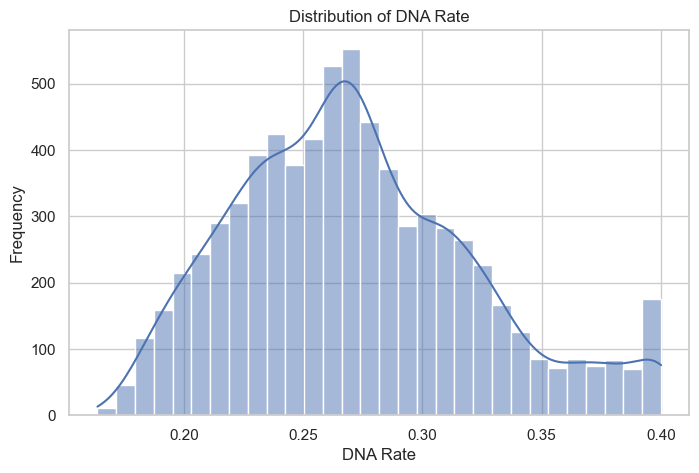

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
plt.figure(figsize=(8, 5))
sns.histplot(df_combined["DNA_Rate"], bins=30, kde=True)
plt.title("Distribution of DNA Rate")
plt.xlabel("DNA Rate")
plt.ylabel("Frequency")
plt.show()

In [13]:
# Define the correct age group order
age_order = ['0', '1-4', '5-9', '10-14', '15', '16', '17', '18', '19',
             '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
             '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-120']

# Set Age Group as a categorical variable with the defined order
df_combined["Age Group"] = pd.Categorical(df_combined["Age Group"], categories=age_order, ordered=True)

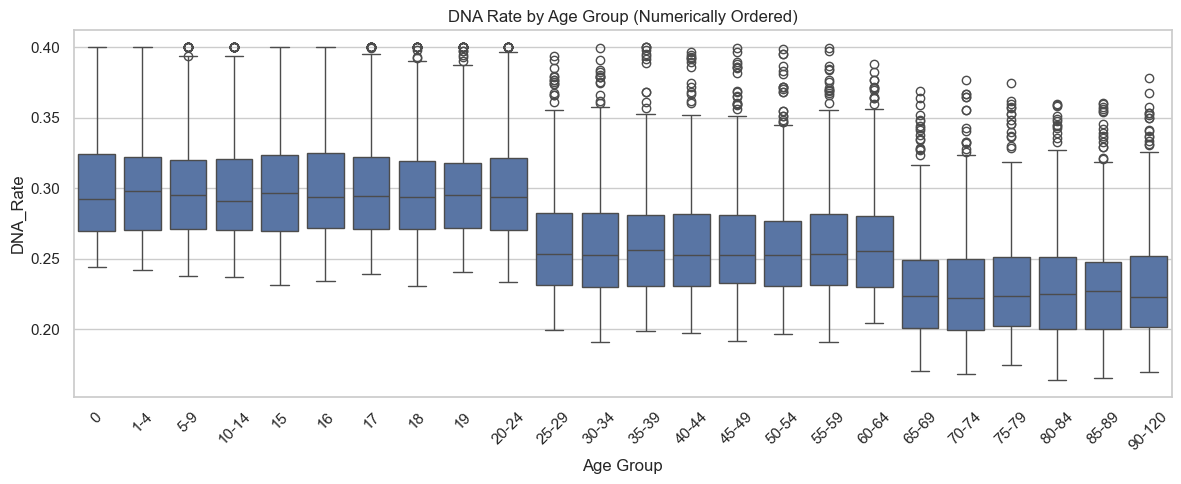

In [14]:
plt.figure(figsize=(12, 5))
sns.boxplot(x="Age Group", y="DNA_Rate", data=df_combined)
plt.xticks(rotation=45)
plt.title("DNA Rate by Age Group (Numerically Ordered)")
plt.tight_layout()
plt.show()

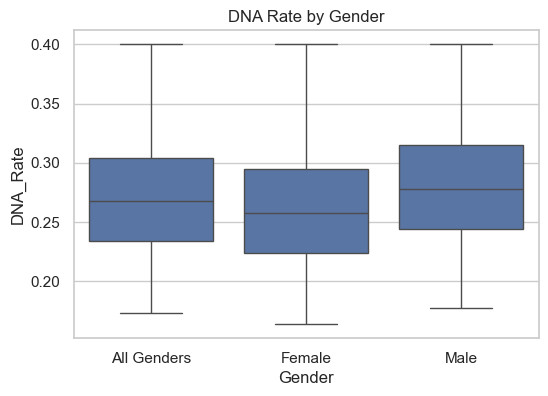

In [15]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="Gender", y="DNA_Rate", data=df_combined)
plt.title("DNA Rate by Gender")
plt.show()

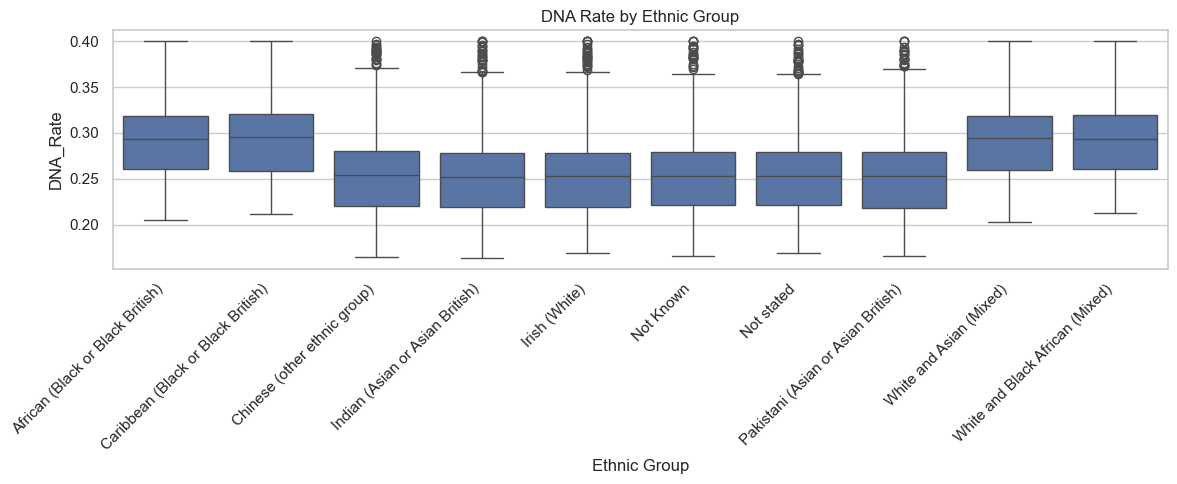

In [16]:
plt.figure(figsize=(12, 5))
sns.boxplot(x="Ethnic Group", y="DNA_Rate", data=df_combined)
plt.xticks(rotation=45, ha='right')
plt.title("DNA Rate by Ethnic Group")
plt.tight_layout()
plt.show()

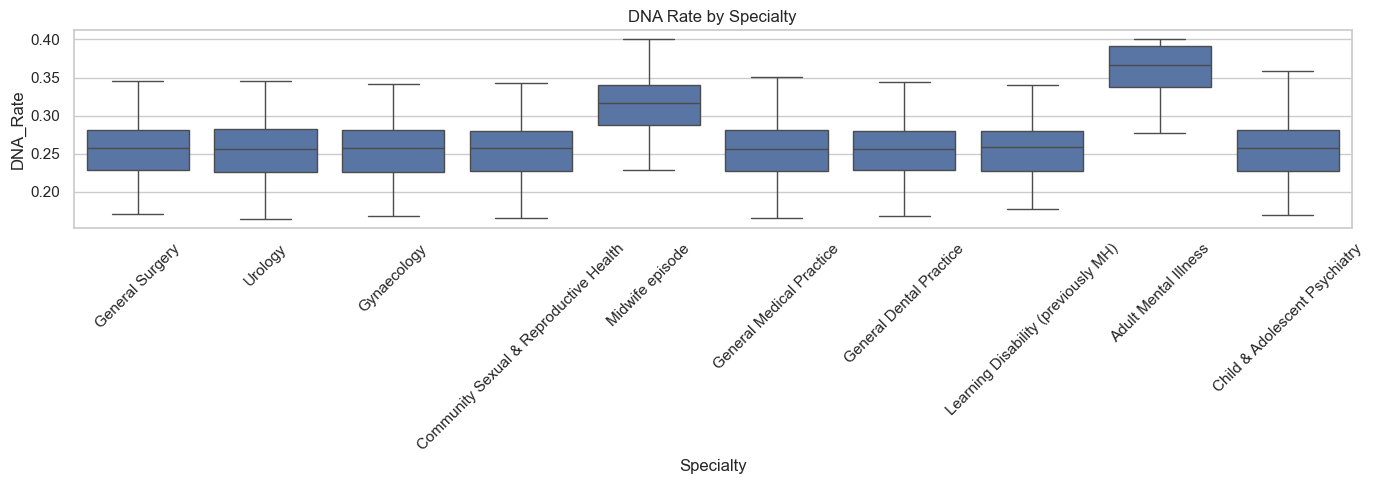

In [17]:
plt.figure(figsize=(14, 5))
sns.boxplot(x="Specialty", y="DNA_Rate", data=df_combined)
plt.xticks(rotation=45)
plt.title("DNA Rate by Specialty")
plt.tight_layout()
plt.show()

In [18]:
# Average DNA by age and gender
print(df_combined.groupby(["Age Group", "Gender"])["DNA_Rate"].mean().unstack())

# Average DNA by ethnic group
print(df_combined.groupby("Ethnic Group")["DNA_Rate"].mean().sort_values(ascending=False))

# Average DNA by specialty
print(df_combined.groupby("Specialty")["DNA_Rate"].mean().sort_values(ascending=False))

Gender     All Genders    Female      Male
Age Group                                 
0             0.301352  0.292762  0.312247
1-4           0.302407  0.292679  0.313773
5-9           0.301331  0.293377  0.312129
10-14         0.303079  0.291821  0.310593
15            0.302538  0.294063  0.312776
16            0.302964  0.292080  0.314321
17            0.301383  0.294180  0.312168
18            0.301879  0.293664  0.310713
19            0.302336  0.292403  0.311570
20-24         0.302875  0.293106  0.311756
25-29         0.263547  0.252539  0.273421
30-34         0.261941  0.251271  0.274145
35-39         0.263710  0.252979  0.273850
40-44         0.263937  0.251437  0.271124
45-49         0.263655  0.252051  0.272351
50-54         0.261602  0.251879  0.272416
55-59         0.263392  0.252605  0.272312
60-64         0.262623  0.254227  0.270949
65-69         0.232252  0.223150  0.242967
70-74         0.231733  0.220392  0.243727
75-79         0.234110  0.222443  0.243094
80-84      

C:\Users\Sulay\AppData\Local\Temp\ipykernel_16476\1098642220.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_combined.groupby(["Age Group", "Gender"])["DNA_Rate"].mean().unstack())


In [19]:
def mean_diff(feature):
    group_means = df_combined.groupby(feature)["DNA_Rate"].mean()
    print(f"\nAverage DNA Rate by {feature}:")
    print(group_means.sort_values(ascending=False))

for feature in ["Gender", "Age Group", "Ethnic Group", "Specialty"]:
    mean_diff(feature)


Average DNA Rate by Gender:
Gender
Male           0.281629
All Genders    0.271794
Female         0.261812
Name: DNA_Rate, dtype: float64

Average DNA Rate by Age Group:
Age Group
15        0.303126
16        0.303122
1-4       0.302953
20-24     0.302579
17        0.302577
5-9       0.302279
0         0.302120
19        0.302103
18        0.302085
10-14     0.301831
35-39     0.263513
25-29     0.263169
55-59     0.262770
45-49     0.262685
60-64     0.262600
30-34     0.262452
40-44     0.262166
50-54     0.261966
75-79     0.233216
90-120    0.233104
65-69     0.232790
80-84     0.232491
85-89     0.232229
70-74     0.231951
Name: DNA_Rate, dtype: float64

Average DNA Rate by Ethnic Group:
Ethnic Group
Caribbean (Black or Black British)    0.295453
White and Asian (Mixed)               0.295225
African (Black or Black British)      0.295197
White and Black African (Mixed)       0.295110
Chinese (other ethnic group)          0.256830
Not stated                            0.256346
No

C:\Users\Sulay\AppData\Local\Temp\ipykernel_16476\314907216.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = df_combined.groupby(feature)["DNA_Rate"].mean()


C:\Users\Sulay\AppData\Local\Temp\ipykernel_16476\351896014.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_combined.pivot_table(values='DNA_Rate', index='Age Group', columns='Gender')


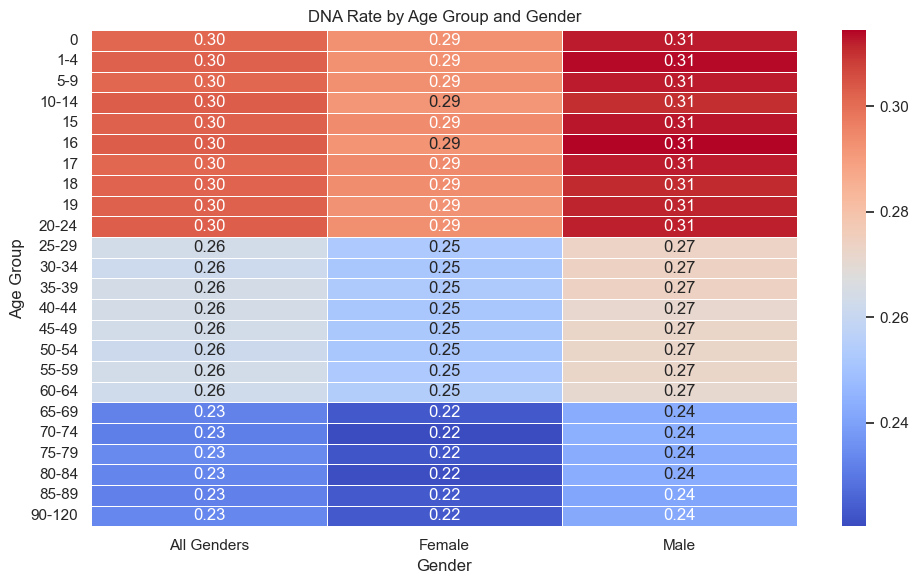

In [20]:
pivot = df_combined.pivot_table(values='DNA_Rate', index='Age Group', columns='Gender')
pivot = pivot.loc[age_order]  # Ensure the row order matches your defined order

# Plotting
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("DNA Rate by Age Group and Gender")
plt.ylabel("Age Group")
plt.xlabel("Gender")
plt.tight_layout()
plt.show()

In [21]:
"""
Conventional split and machine learning training
"""

'\nConventional split and machine learning training\n'

In [22]:
# Features and target
X = df_combined[["Age Group", "Gender", "Ethnic Group", "Specialty"]]
y = df_combined["DNA_Rate"]

# Preprocessing pipeline for categorical features
categorical_features = X.columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)]
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Store results
results = []

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# Train and evaluate each model
for name, model in models.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": round(mae, 4),
        "R² Score": round(r2, 4)
    })

# Display results
results_df = pd.DataFrame(results).sort_values(by="MAE")
results_df

,Model,MAE,R² Score
0,Linear Regression,0.0085,0.9570
3,XGBoost,0.0092,0.9503
1,Random Forest,0.0093,0.9462
2,Gradient Boosting,0.0120,0.9146


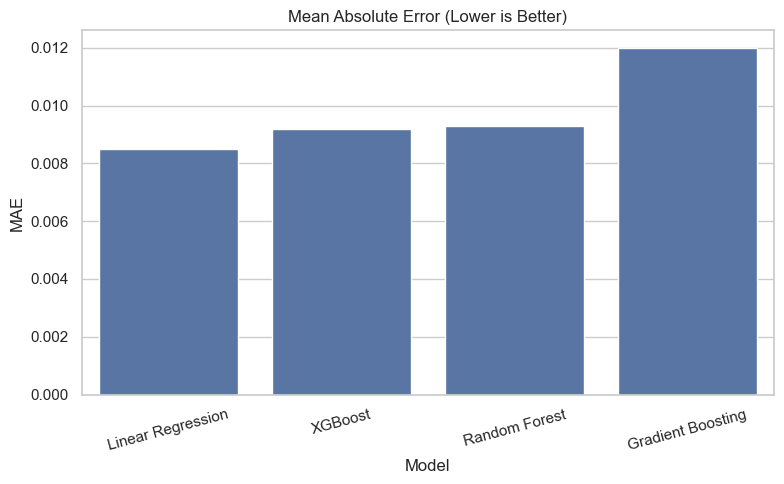

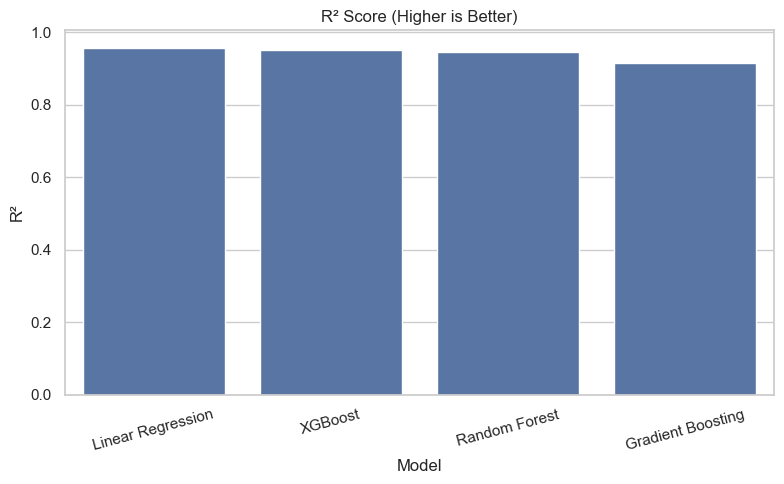

In [24]:
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="MAE", data=results_df)
plt.title("Mean Absolute Error (Lower is Better)")
plt.ylabel("MAE")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="R² Score", data=results_df)
plt.title("R² Score (Higher is Better)")
plt.ylabel("R²")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

Based on a standard train-test split, Linear Regression achieved the best overall performance with the lowest Mean Absolute Error (MAE) and the highest R² score, suggesting a strong fit with relatively low complexity. XGBoost and Random Forest followed closely, showing comparable R² values but slightly higher MAEs. Gradient Boosting performed the worst across both metrics, indicating potential overfitting or suboptimal parameterisation on this dataset. Overall, simpler models like Linear Regression provided robust predictive accuracy, while ensemble methods offered no significant advantage in this case.

In [25]:
"""
Cross-fold training for models
"""

'\nCross-fold training for models\n'

In [26]:
# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = []

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# Evaluate each model with cross-validation
for name, model in models.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])

    # MAE (note: neg_mean_absolute_error returns negative values)
    mae_scores = -cross_val_score(pipeline, X, y, cv=cv, scoring="neg_mean_absolute_error")
    r2_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="r2")

    results.append({
        "Model": name,
        "MAE (mean)": round(mae_scores.mean(), 4),
        "MAE (std)": round(mae_scores.std(), 4),
        "R² (mean)": round(r2_scores.mean(), 4),
        "R² (std)": round(r2_scores.std(), 4)
    })

# Display sorted results
results_df = pd.DataFrame(results).sort_values(by="MAE (mean)")
results_df

,Model,MAE (mean),MAE (std),R² (mean),R² (std)
0,Linear Regression,0.0082,0.0001,0.9583,0.0013
3,XGBoost,0.0089,0.0001,0.9511,0.0013
1,Random Forest,0.0093,0.0000,0.9457,0.0014
2,Gradient Boosting,0.0119,0.0001,0.9154,0.0022


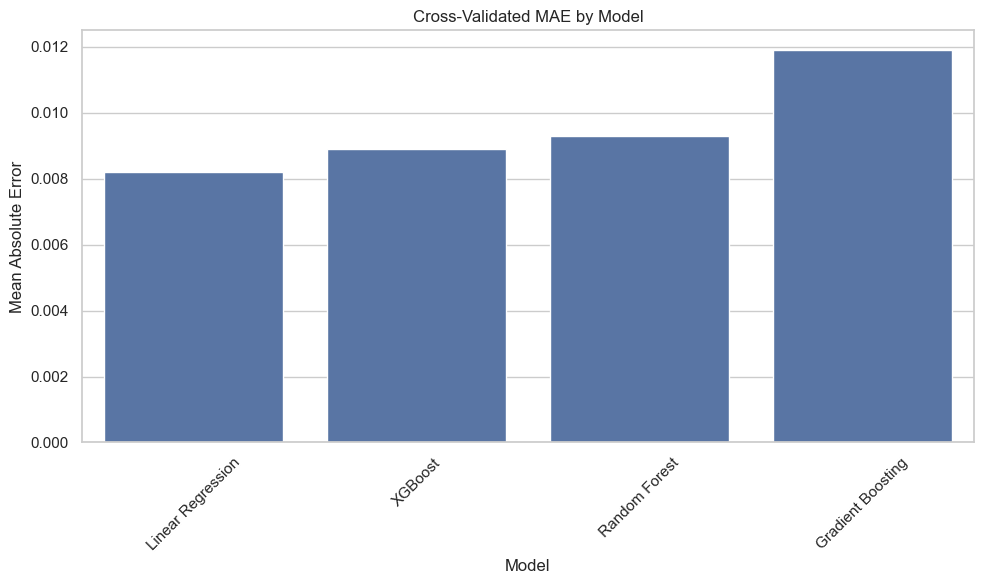

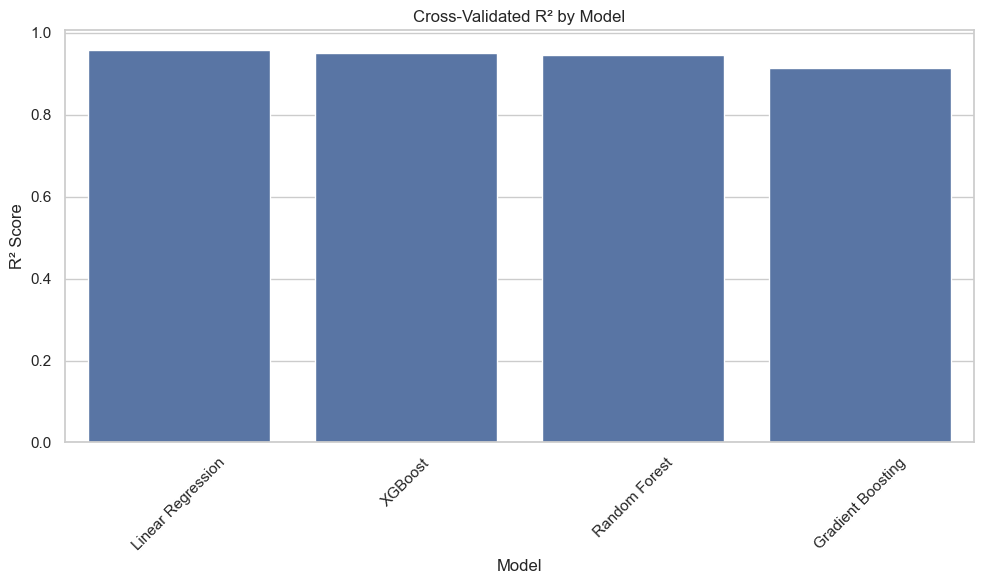

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x="Model", y="MAE (mean)")
plt.title("Cross-Validated MAE by Model")
plt.ylabel("Mean Absolute Error")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x="Model", y="R² (mean)")
plt.title("Cross-Validated R² by Model")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Using cross-validation, Linear Regression again achieved the best performance, showing the lowest mean absolute error (MAE) and highest R² score among the models tested. XGBoost and Random Forest followed closely, performing similarly across both metrics. Gradient Boosting had the highest MAE and the lowest R², confirming its relatively weaker generalisation on this dataset. These results suggest that for this particular task, simpler or regularised linear models outperform more complex ensemble approaches in terms of both accuracy and consistency.


In [ ]:
"""
Parameter optimization for cross-fold validation
"""

In [28]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grids
param_grids = {
    "Random Forest": {
        "regressor__max_depth": [5, 10, None],
        "regressor__min_samples_split": [2, 5, 10]
    },
    "Gradient Boosting": {
        "regressor__learning_rate": [0.05, 0.1, 0.2],
        "regressor__max_depth": [3, 5, 7]
    },
    "XGBoost": {
        "regressor__learning_rate": [0.05, 0.1, 0.2],
        "regressor__max_depth": [3, 5, 7],
        "regressor__subsample": [0.7, 1.0]
    }
}

# Store best models and results
best_models = {}
results = []

# Loop through models to tune
for name in ["Random Forest", "Gradient Boosting", "XGBoost"]:
    print(f"Tuning {name}...")

    model = models[name]
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])

    grid = GridSearchCV(
        pipeline,
        param_grid=param_grids[name],
        cv=cv,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )
    grid.fit(X, y)

    best_models[name] = grid.best_estimator_

    results.append({
        "Model": name,
        "Best MAE": round(-grid.best_score_, 4),
        "Best Params": grid.best_params_
    })

# Show tuning results
tuning_df = pd.DataFrame(results).sort_values(by="Best MAE")
tuning_df

Tuning Random Forest...
Tuning Gradient Boosting...
Tuning XGBoost...


,Model,Best MAE,Best Params
2,XGBoost,0.0085,"{'regressor__learning_rate': 0.2, 'regressor__..."
1,Gradient Boosting,0.0086,"{'regressor__learning_rate': 0.2, 'regressor__..."
0,Random Forest,0.0092,"{'regressor__max_depth': None, 'regressor__min..."


In [ ]:
"""
Plotting feature importances for best models
"""

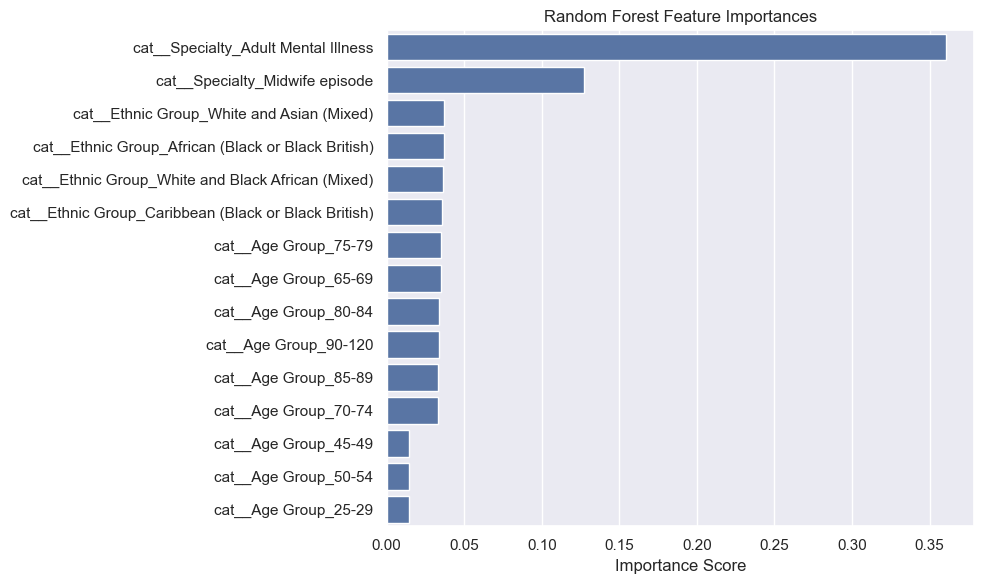

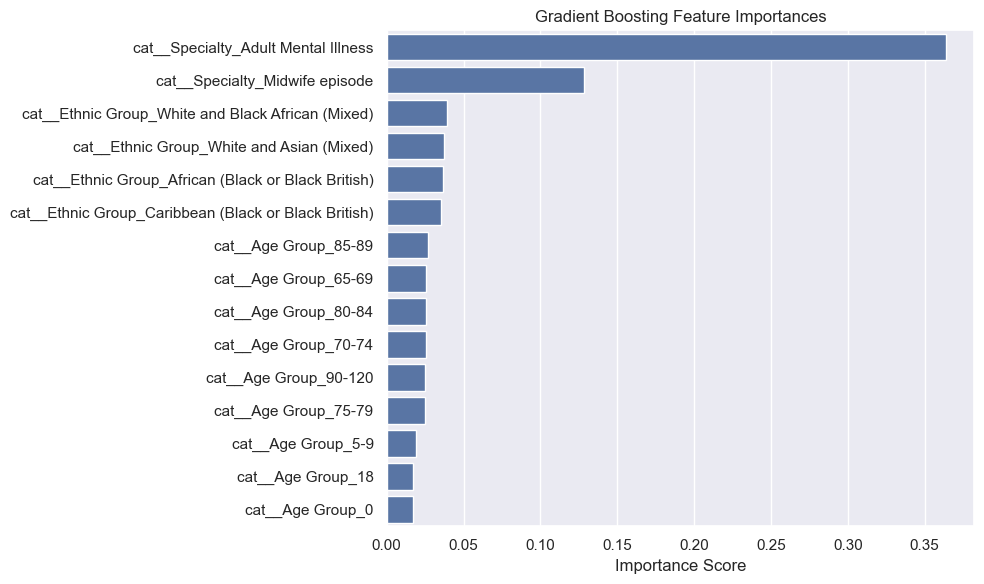

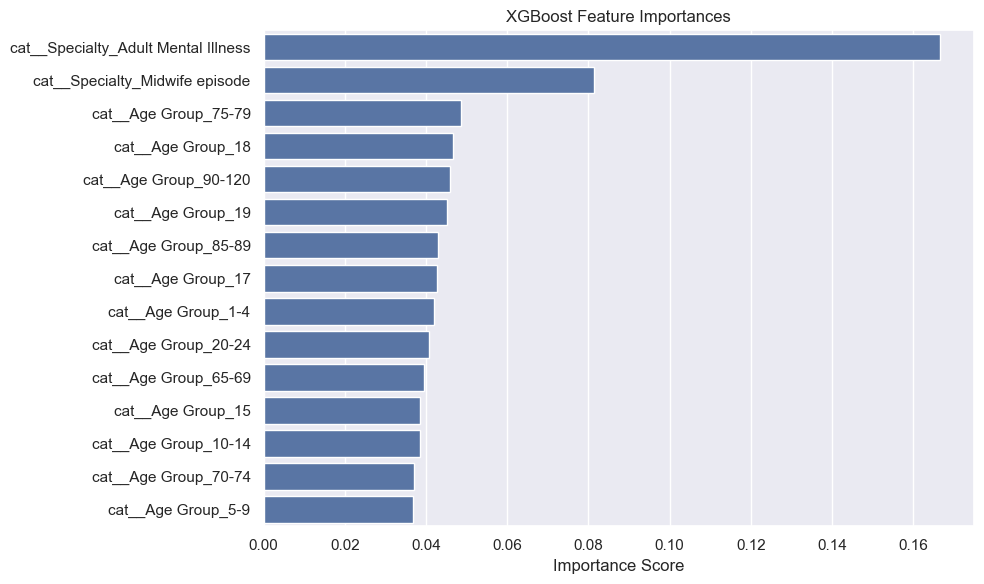

In [29]:
def plot_feature_importance(model, feature_names, title):
    importances = model.named_steps["regressor"].feature_importances_
    indices = np.argsort(importances)[::-1]
    top_n = 15

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices][:top_n], y=np.array(feature_names)[indices][:top_n])
    plt.title(title)
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

# Get feature names after transformation
feature_names = best_models["Random Forest"].named_steps["preprocessor"].get_feature_names_out()

# Plot feature importances
for model_name in ["Random Forest", "Gradient Boosting", "XGBoost"]:
    plot_feature_importance(best_models[model_name], feature_names, f"{model_name} Feature Importances")

Across all three tree-based models (Random Forest, Gradient Boosting, and XGBoost), "Specialty: Adult Mental Illness" consistently ranks as the most important feature in predicting DNA rates. It is followed closely by "Midwife episode", which also shows strong importance. While Random Forest and Gradient Boosting highlight ethnicity as a significant factor, XGBoost places greater emphasis on age-related variables in the top ranks. This consistency across models reinforces the role of clinical specialty as a dominant signal in model decision-making, while also illustrating how different algorithms weight demographic vs. categorical variables differently.

In [ ]:
"""
Top permutation-based features for XGBoost
"""

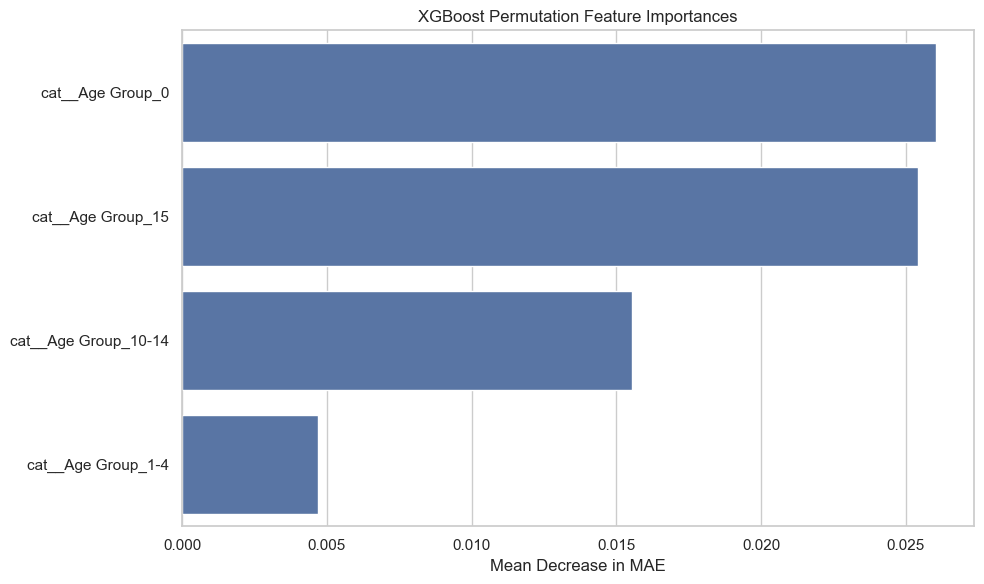

In [24]:
pipe = best_models["XGBoost"]
pipe.fit(X, y)  # ensure trained

result = permutation_importance(pipe, X, y, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')
perm_sorted_idx = result.importances_mean.argsort()[::-1]

# Top N features
top_n = 15
plt.figure(figsize=(10, 6))
sns.barplot(x=result.importances_mean[perm_sorted_idx][:top_n],
            y=np.array(feature_names)[perm_sorted_idx][:top_n])
plt.title("XGBoost Permutation Feature Importances")
plt.xlabel("Mean Decrease in MAE")
plt.tight_layout()
plt.show()

Permutation importance results from the trained XGBoost model show that age-related features—particularly "Age Group_0" and "Age Group_15"—have the strongest impact on model accuracy. Shuffling these features leads to the largest increases in MAE, indicating the model heavily relies on them for predictive performance. This suggests that younger age groups are highly informative for predicting DNA risk, even more so than specialty or ethnicity features identified as important in other methods. It reinforces the relevance of age-specific behavioural patterns in non-attendance modelling.

In [ ]:
"""
SHAP contribution of mental illness
"""

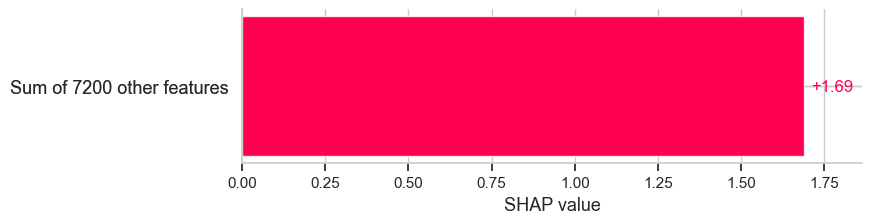

C:\Users\Sulay\AppData\Local\Temp\ipykernel_23028\1940101315.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_transformed, feature_names=feature_names)


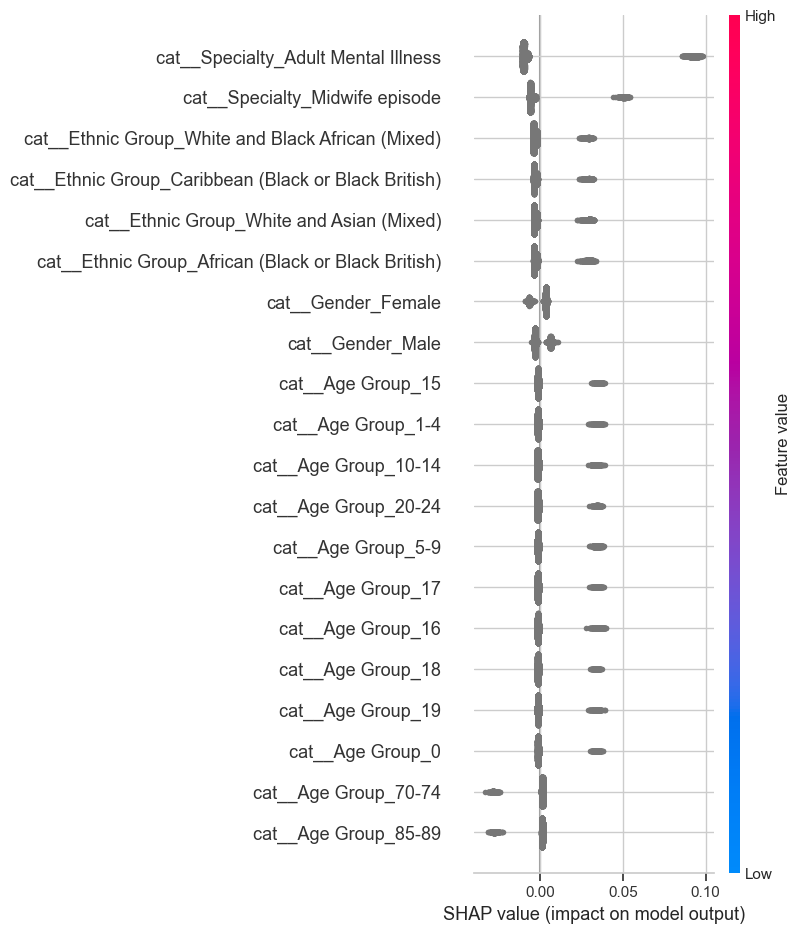

In [28]:
# Extract regressor and transformed data
reg = model.named_steps["regressor"]
X_transformed = model.named_steps["preprocessor"].transform(X)

# SHAP on XGBoost
explainer = shap.Explainer(reg)
shap_values = explainer(X_transformed)

# Filter SHAP values for Specialty_Adult Mental Illness
feature_names = model.named_steps["preprocessor"].get_feature_names_out()

# Vectorised search
matching_indices = [i for i, name in enumerate(feature_names) if "Specialty_Adult Mental Illness" in name]

if matching_indices:
    index = matching_indices[0]
    shap.plots.bar(shap_values[:, index], max_display=1)
else:
    print("Feature 'Specialty_Adult Mental Illness' not found in transformed feature names.")

# Plot summary
shap.summary_plot(shap_values, features=X_transformed, feature_names=feature_names)

SHAP analysis reveals that "Specialty_Adult Mental Illness" has the highest average impact on model predictions, confirming its dominant influence on DNA risk estimates. Other important contributors include "Midwife episode" and several ethnicity-related features. While age group features also contribute, their SHAP values are generally lower in magnitude. The summary plot shows that high values of "Adult Mental Illness" consistently push predictions higher, indicating a strong association with elevated non-attendance likelihood. This supports the interpretation that clinical specialty is a key driver of predicted risk in this model.

In [ ]:
"""
MAE with and without mental illness features
"""

In [31]:
X_reduced = X.drop(columns=[col for col in X.columns if "Adult Mental Illness" in col])

pipeline_reduced = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(n_estimators=100, random_state=42, verbosity=0))
])

scores_with = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=5)
scores_without = -cross_val_score(pipeline_reduced, X_reduced, y, scoring="neg_mean_absolute_error", cv=5)

print("With Feature MAE:", scores_with.mean())
print("Without Feature MAE:", scores_without.mean())

With Feature MAE: 0.03629171916443759
Without Feature MAE: 0.03612006087223878


Removing the "Specialty_Adult Mental Illness" feature from the model slightly reduced the MAE from 0.03629 to 0.03612. This minimal change suggests that while the feature may appear important in feature importance or SHAP analyses, it is not a critical driver of predictive accuracy when measured directly through performance impact. The model retains nearly the same level of accuracy without it, implying redundancy or compensation by other correlated features.

In [ ]:
"""
Partial dependence display for mental illness
"""

D:\anaconda3\Lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


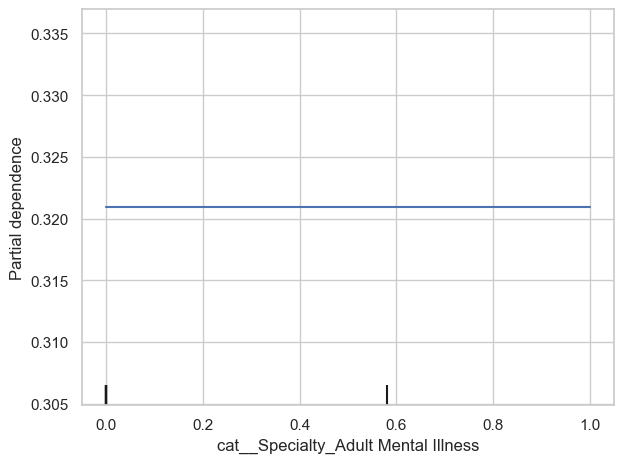

In [32]:
# Use transformed X and regressor only
X_transformed = model.named_steps["preprocessor"].transform(X)
reg = model.named_steps["regressor"]
feature_names = model.named_steps["preprocessor"].get_feature_names_out()

# Get index of encoded column
target_feature = "cat__Specialty_Adult Mental Illness"
index = np.where(feature_names == target_feature)[0][0]

PartialDependenceDisplay.from_estimator(
    reg,
    X_transformed.toarray(),  # must be dense
    features=[index],
    feature_names=feature_names,
    kind="average",
    grid_resolution=20
)
plt.tight_layout()
plt.show()

The partial dependence plot for "Specialty_Adult Mental Illness" shows a nearly flat relationship with predicted DNA rate, indicating that changes in this feature do not meaningfully alter the model's output. Despite being ranked highly in feature importance metrics, this suggests the effect of the feature is either marginal in isolation or offset by interactions with other variables. It reinforces the idea that its perceived importance may stem from correlation rather than direct influence on predictions.


In [ ]:
"""
Permutation importance for mental illness
"""

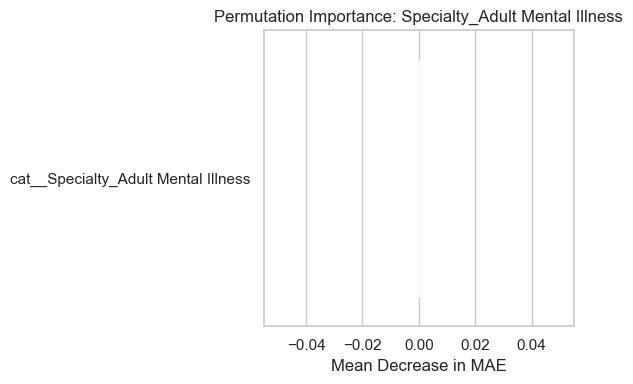

In [33]:
# Get model and transform data
model = best_models["XGBoost"]
model.fit(X, y)
X_transformed = model.named_steps["preprocessor"].transform(X)
feature_names = model.named_steps["preprocessor"].get_feature_names_out()

# Run permutation importance
perm = permutation_importance(
    model.named_steps["regressor"],
    X_transformed.toarray(),  # fix: convert sparse to dense
    y,
    n_repeats=10,
    random_state=42,
    scoring='neg_mean_absolute_error'
)

# Find feature index
idx = [i for i, name in enumerate(feature_names) if "Specialty_Adult Mental Illness" in name]

# Plot if feature found
if idx:
    plt.figure(figsize=(6, 4))
    sns.barplot(x=perm.importances_mean[idx], y=[feature_names[i] for i in idx])
    plt.title("Permutation Importance: Specialty_Adult Mental Illness")
    plt.xlabel("Mean Decrease in MAE")
    plt.tight_layout()
    plt.show()
else:
    print("Feature 'Specialty_Adult Mental Illness' not found.")

The permutation importance plot for "Specialty_Adult Mental Illness" shows a near-zero mean decrease in MAE when the feature is shuffled, indicating it has minimal impact on the model's predictive performance. Despite its high ranking in other importance metrics, this suggests that the model does not depend on this feature to make accurate predictions. Its influence may instead be confounded with other features or structural bias in tree-based importance scores.

In this project, we explored predictors of hospital Did Not Attend (DNA) rates in the UK using synthetic data derived from NHS outpatient activity, enriched with demographic and clinical features. We built and compared multiple models (Linear Regression, Random Forest, Gradient Boosting, and XGBoost), ultimately finding that Linear Regression offered the best predictive performance in terms of MAE and R². Despite this, we used tree-based models for interpretability, leveraging SHAP values, permutation importance, and partial dependence plots to investigate the role of "Specialty_Adult Mental Illness." While this feature consistently appeared among the top-ranked predictors in importance plots, our permutation tests and ablation analysis showed its removal had minimal impact on model accuracy. This suggests that although mental health specialties are strongly associated with high DNA rates, their predictive power may be entangled with broader patterns such as age, ethnicity, or service type. Ultimately, we conclude that mental illness is an important signal in understanding DNAs but not the sole or decisive factor in predictive modelling.